In [22]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing;
from sklearn.model_selection import cross_validate as cross_validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# %matplotlib inline

In [24]:
import datetime
from datetime import timedelta
forecast_out = 365 #Days from now

stock_ticker ='V'
stock_parameter ='Low'
epoch_number=50
epoch_number_forecast=50

end = datetime.datetime.now()#-timedelta(7) #remove timedetla -1 to go to productions mode
start = datetime.datetime.now()-timedelta(forecast_out)

# benchmark = web.DataReader(stock_ticker, 'yahoo', start, end )
stock = web.DataReader(stock_ticker, 'yahoo', start, end)


In [26]:
test_size=20
test_index = len(stock[stock_parameter])- test_size

In [28]:
train = stock[stock_parameter].iloc[:test_index]
test= stock[stock_parameter].iloc[test_index:]

In [30]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
scaler=MinMaxScaler()
scaler.fit(train.to_frame())
scaled_train = scaler.transform(train.to_frame())
scaled_test = scaler.transform(test.to_frame())

In [34]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [36]:
length=test_size-1
generator = TimeseriesGenerator(scaled_train,scaled_train, length=length, batch_size=1)

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [40]:
n_features =1
model= Sequential()
# pretty good model at 200 epochs
# model.add(LSTM(50, activation='relu', input_shape=(length, n_features)))
# model.add(Dropout(0.2))
# model.add(Dense(25, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.2))

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='SGD', loss='mse')

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=1)

In [42]:
validation_generator= TimeseriesGenerator(scaled_test, scaled_test,
                                          length=length, batch_size =1)

In [43]:
# model.fit_generator(generator, epochs=20,
#                    validation_data=validation_generator, callbacks=[early_stop])
model.fit_generator(generator, epochs=epoch_number,
                   validation_data=validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 212 steps, validate for 1 steps
Epoch 1/50
212/212 [==============================] - 7s 33ms/step - loss: 0.0503 - val_loss: 0.0042
Epoch 2/50
212/212 [==============================] - 2s 10ms/step - loss: 0.0326 - val_loss: 0.0010
Epoch 3/50
212/212 [==============================] - 2s 11ms/step - loss: 0.0271 - val_loss: 3.1376e-04
Epoch 4/50
212/212 [==============================] - 2s 11ms/step - loss: 0.0262 - val_loss: 0.0012
Epoch 5/50
212/212 [==============================] - 3s 12ms/step - loss: 0.0224 - val_loss: 0.0024
Epoch 6/50
212/212 [==============================] - 3s 12ms/step - loss: 0.0207 - val_loss: 2.7440e-04
Epoch 7/50
212/212 [==============================] - 3s 14ms/step - loss: 0.0178 - val_loss: 8.3328e-05
Epoch 8/50
212/212 [==============================] - 3s 13ms/step - loss: 0.0170 - val_loss: 5.1921e-04
Epoch 9/50
212/212 [==============================] - 3s 12ms/step - loss: 0.0149 - 

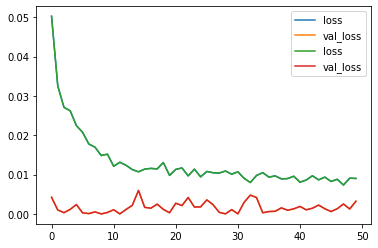

In [44]:
losses= pd.DataFrame(model.history.history)
ax =losses.plot()
losses.plot(ax=ax)
plt.savefig(stock_ticker+'_'+stock_parameter+'loss_chart.png')

In [45]:
test_predictions =[]
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [46]:
true_predictions =scaler.inverse_transform(test_predictions)


In [47]:
predictions = pd.DataFrame(test)
predictions['Predictions'] = true_predictions

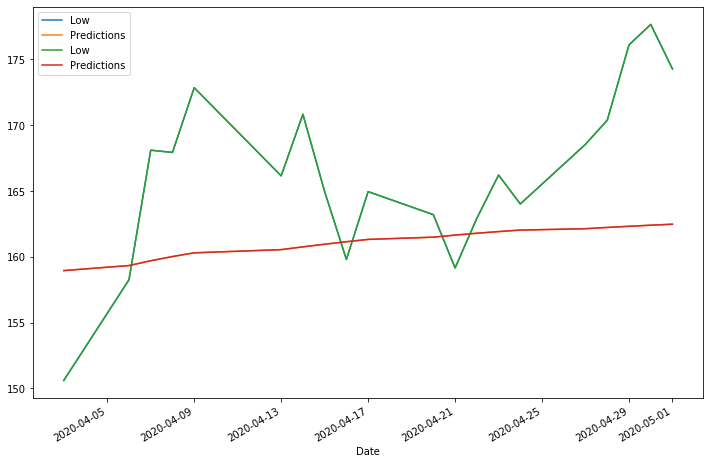

In [48]:
ax=predictions.plot(figsize=(12,8))
predictions.plot(ax=ax)
plt.savefig(stock_ticker+'_'+stock_parameter+'_predictions_chart.png')

In [49]:
from keras.models import load_model
model.save(stock_ticker+'_'+stock_parameter+'prediction'+'.h5')

# Forecasting

In [50]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(stock[stock_parameter].to_frame())

In [51]:
length=19
generator=TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [52]:
forecast_model= Sequential()
forecast_model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
forecast_model.add(Dropout(0.2))
forecast_model.add(Dense(50, activation='relu'))
forecast_model.add(Dropout(0.2))
forecast_model.add(Dense(15, activation='relu'))
forecast_model.add(Dropout(0.2))
forecast_model.add(Dense(1, activation='relu'))
forecast_model.compile(optimizer='SGD', loss='mse')
forecast_model.fit_generator(generator, epochs=epoch_number_forecast)

  ...
    to  
  ['...']
Train for 232 steps
Epoch 1/50
232/232 [==============================] - 7s 29ms/step - loss: 0.0407
Epoch 2/50
232/232 [==============================] - 2s 9ms/step - loss: 0.0206
Epoch 3/50
232/232 [==============================] - 2s 9ms/step - loss: 0.0195
Epoch 4/50
232/232 [==============================] - 3s 11ms/step - loss: 0.0151
Epoch 5/50
232/232 [==============================] - 3s 11ms/step - loss: 0.0135
Epoch 6/50
232/232 [==============================] - 2s 10ms/step - loss: 0.0117
Epoch 7/50
232/232 [==============================] - 2s 10ms/step - loss: 0.0115
Epoch 8/50
232/232 [==============================] - 2s 11ms/step - loss: 0.0122
Epoch 9/50
232/232 [==============================] - 2s 10ms/step - loss: 0.0126
Epoch 10/50
231/232 [============================>.] - ETA: 0s - loss: 0.010232/232 [==============================] - 2s 10ms/step - loss: 0.0109
Epoch 11/50
232/232 [==============================] - 3s 11ms/step - lo

In [53]:
from keras.models import load_model
model.save(stock_ticker+'_'+stock_parameter+'forecast'+'.h5')

In [54]:
forecast =[]

periods=19

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [55]:
forecast = scaler.inverse_transform(forecast)

In [56]:
forecast

array([[170.71489189],
       [170.30640339],
       [169.90199051],
       [169.5369752 ],
       [169.18719359],
       [168.87558086],
       [168.57398559],
       [168.28971284],
       [168.02006174],
       [167.75752326],
       [167.5060316 ],
       [167.26626137],
       [167.03343683],
       [166.8074189 ],
       [166.59077162],
       [166.37881199],
       [166.17320225],
       [165.97317271],
       [165.78086087]])

In [57]:
from datetime import date
forecast_index = pd.date_range(start=date.today(), periods = periods, freq="D")

In [58]:
forecast_df = pd.DataFrame(data = forecast, index=forecast_index, columns=['Forecast'])

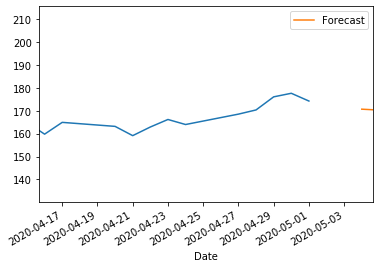

In [59]:
ax=stock[stock_parameter].plot()
forecast_df.plot(ax=ax)
plt.xlim( datetime.datetime.now()-timedelta(periods), datetime.datetime.now())
plt.savefig(stock_ticker+'_'+stock_parameter+'forecast_chart.png')


In [60]:
forecast_df.to_csv('forecast_'+stock_ticker+'_'+stock_parameter+'.csv')